### Noise Injection with the Laplace Mechanism

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests, zipfile, io

This notebook explores one disclosure avoidance technique that injects Laplacian-distributed noise to tabulated the Public Use Microdata Sample(PUMS) data. First, let's download the PUMS data and read it into a pandas dataframe.

In [3]:
r = requests.get('https://www2.census.gov/programs-surveys/acs/data/pums/2017/5-Year/csv_ppa.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extract('psam_p42.csv')
pa = pd.read_csv("psam_p42.csv")

Next, lets filter the data to contain only relevant variables and people.  
In our example we will focus on educational attainment and race for all person above the age of 18.   
For variable defintions see:
https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMS_Data_Dictionary_2017.pdf

In [4]:
#Filtering geographic location, race, educational attainment, total income in past 12 months and age for all 18+ PA persons
new_pa = pa.query("AGEP>=18").filter(items=['PUMA','RAC1P','RAC2P','SCHL','WAGP','PINCP','AGEP'])
new_pa.head()

,PUMA,RAC1P,SCHL,WAGP,PINCP,AGEP
0,1300,1,16.0,0.0,7300.0,83
1,1300,1,21.0,0.0,11000.0,69
2,3401,1,22.0,0.0,75200.0,68
3,3401,1,21.0,0.0,36400.0,67
4,4002,1,19.0,0.0,2600.0,47


In [24]:
#create a table showing total count of educational attaninment of adults in PA by race. 
pivot_pa = pd.pivot_table(new_pa,
                              index='RAC1P',
                              columns='SCHL',
                              values='PINCP',
                              aggfunc=np.size,
                              margins=True)

pivot_pa.columns = ['No schooling','preschool','K','Grade 1','Grade 2','Grade 3','Grade 4','Grade 5','Grade 6','Grade 7','Grade 8'
                        ,'Grade 9','Grade 10','Grade 11','Grade 12-no diploma','HS diploma','GED','some college','1+ year college','Associate',
                        'Bachelor','Master','Professional','Doctorate','ALL']
#TODO: rename columns for clarity.
pivot_pa.head(10)


,No schooling,preschool,K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5,Grade 6,Grade 7,...,HS diploma,GED,some college,1+ year college,Associate,Bachelor,Master,Professional,Doctorate,ALL
RAC1P,,,,,,,,,,,,,,,,,,,,,
1,3749.0,54.0,48.0,53.0,73.0,230.0,192.0,301.0,760.0,880.0,...,155828.0,17058.0,28869.0,52859.0,37029.0,76093.0,33779.0,7413.0,5328.0,456843.0
2,633.0,10.0,12.0,9.0,20.0,39.0,27.0,58.0,116.0,118.0,...,10704.0,2521.0,2696.0,6011.0,2318.0,3326.0,1607.0,271.0,234.0,35469.0
3,10.0,1.0,1.0,NaN,1.0,2.0,NaN,1.0,16.0,4.0,...,144.0,36.0,40.0,75.0,33.0,68.0,37.0,4.0,6.0,543.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,2.0,1.0,2.0,NaN,NaN,2.0,1.0,NaN,1.0,10.0
5,10.0,NaN,NaN,2.0,4.0,2.0,4.0,NaN,3.0,5.0,...,69.0,17.0,19.0,36.0,19.0,22.0,3.0,5.0,1.0,268.0
6,571.0,1.0,4.0,9.0,21.0,32.0,35.0,65.0,116.0,53.0,...,1847.0,163.0,583.0,1363.0,515.0,2982.0,1834.0,666.0,695.0,12446.0
7,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,35.0,10.0,10.0,15.0,6.0,16.0,12.0,1.0,2.0,122.0
8,225.0,2.0,2.0,12.0,14.0,45.0,34.0,53.0,129.0,60.0,...,1397.0,329.0,329.0,588.0,267.0,356.0,117.0,33.0,25.0,5044.0
9,77.0,4.0,1.0,3.0,4.0,9.0,11.0,13.0,34.0,21.0,...,1415.0,337.0,531.0,1135.0,456.0,877.0,348.0,107.0,67.0,6079.0


**The Laplace Mechanism**
The input is mu - a number or a numpy array, along with the privacy budget epsilon and sensitivity of the query that produced mu.

In [14]:
def laplace_mech(mu, epsilon, sensitivity=1.0):
    """Implementation of the Laplace Mechanism that adds Laplacian-distributed noise to a function.
  　
    Args:
      mu (float or numpy array): the true answer
      epsilon(int): the privacy budget
      sensitivity (float): the global sensitivity of the query
    """
    eps = epsilon/float(sensitivity)
    scale = 1/eps
    np_shape = np.shape(mu)
    shape = None if np_shape == () else np_shape
    z = np.random.laplace(0.0, scale=scale, size=shape)
    return mu + z

### Quality Metrics

While the trade-off between statistical accuracy and privacy loss is at the heart of differential privacy, there are many metrics for assessing the quality of a published dataset. One approach is to calculate the L1 error between the true data (i.e. without disclosure limitation) and the privatized data.

**The L1 Norm** In this simple scenario involving the Laplace Mechanism, the L1 error is a natural metric. This is a coarse measure: a disclosure limited product with a high L1 compared to the same product without disclosure limitation may still be very accurate for its intended use. 

In [15]:
def avg_l1_laplace(epsilon, mu, n=1000):
    """Takes the average error of the laplace mechanism on an array over n samples.
  　
    Args:
      epsilon (int): the privacy budget
      mu (float or numpy array): the true answer
      n (int): number of samples
    """
    total = 0
    for i in range(n):
        noisy_arr = laplace_mech(mu, epsilon, sensitivity=1.0)
        accuracy = 1 - (np.linalg.norm(noisy_arr-mu, 1)/(2*noisy_arr.shape[1]))
        total += accuracy
    return total/n

### Trade-off Between Privacy Loss and Accuracy

When submitting to the DRB, the practitioner prepares a set of graphs that show the trade-off between privacy loss (ϵ) and accuracy. DRB officials then picks a value of ϵ that allows for sufficient accuracy. Officials most often estimate with epsilon values between 1 and 9.

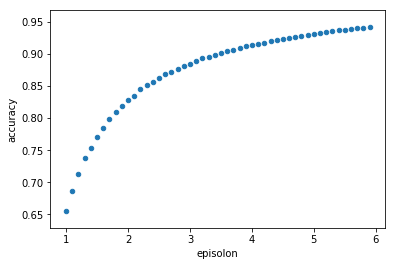

In [42]:
orig_arr = pd.DataFrame(pivot_pa.fillna(0))
accuracy_df = pd.DataFrame()
eps_range = np.arange(1,6.0,.1)
accuracy_df['episolon'] = eps_range
accuracy_df['accuracy'] = [avg_l1_laplace(x, orig_arr) for x in eps_range]
accuracy_df.plot.scatter('episolon', 'accuracy')
plt.show()

### Postprocessing

Postprocessing the output of a DP mechanism does not degrade privacy. In this case, we want to round any negative counts to zero.

In [43]:
noisy_counts = laplace_mech(orig_arr, 3)
noisy_counts

,No schooling,preschool,K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5,Grade 6,Grade 7,...,HS diploma,GED,some college,1+ year college,Associate,Bachelor,Master,Professional,Doctorate,ALL
RAC1P,,,,,,,,,,,,,,,,,,,,,
1,3747.547917,53.912849,48.560097,52.754624,73.137701,229.997894,192.999246,299.348053,759.775072,880.259075,...,155827.932898,17058.480496,28869.015185,52859.152040,37029.393839,76093.292229,33778.899765,7412.469183,5327.817135,456842.713888
2,632.614990,10.362339,12.441807,10.062994,20.884142,39.117402,26.952026,57.610109,116.011847,118.036037,...,10703.773910,2520.803175,2696.143586,6011.123422,2317.828595,3326.029927,1606.970343,270.849269,234.500954,35469.261673
3,9.898712,1.046546,0.829419,-0.551513,0.735194,2.156716,-0.206215,1.035560,16.391422,4.321926,...,143.455582,36.203619,40.282825,76.274546,33.382376,68.361548,37.066440,4.587197,5.673832,543.455084
4,0.512338,0.141123,-0.212933,0.867886,0.518296,0.049412,-0.586615,-0.370520,1.096491,-0.382966,...,2.127653,0.042097,1.983578,-0.122122,-1.097455,1.836156,1.737714,-0.227023,0.554296,10.389235
5,9.245251,-0.620040,0.148704,1.830732,2.918892,2.099534,3.843941,-0.219307,3.377845,5.330186,...,69.002680,16.130532,19.483725,36.277930,19.145190,21.060598,2.937628,4.996135,1.033879,268.287157
6,571.025800,1.141770,4.472362,8.718381,21.337851,31.773311,36.260497,65.010062,115.943111,52.919951,...,1847.906976,163.256785,583.412666,1362.561447,515.784365,2982.068561,1835.061744,665.715363,695.454940,12446.091051
7,4.295137,-0.087056,-0.085251,-0.338249,-0.697275,0.101742,0.214645,-0.230742,-0.430546,0.257309,...,34.919152,9.382456,9.945948,14.273431,5.858721,15.835485,13.309492,-0.328081,1.627754,121.762780
8,224.983797,1.700524,1.926816,11.016341,14.056194,45.134502,34.092942,52.721110,128.499278,59.245725,...,1396.843133,328.822934,330.370150,588.405088,266.761410,355.770188,117.304692,32.653311,25.647032,5043.884239
9,77.119274,4.138302,0.992856,2.935834,3.261242,8.929705,11.299218,12.643386,33.843697,21.333049,...,1414.938783,336.863597,530.874557,1134.793170,456.069517,876.650857,348.311746,106.966498,67.077462,6079.033672


Rounding helper function 

In [35]:
def rounder(x):
    if x < 0:
        return 0 
    return x

In [41]:
#Apply rounder to every cell in new noisy output
rounded_counts = noisy_counts.applymap(rounder)

In [40]:
rounded_counts

,No schooling,preschool,K,Grade 1,Grade 2,Grade 3,Grade 4,Grade 5,Grade 6,Grade 7,...,HS diploma,GED,some college,1+ year college,Associate,Bachelor,Master,Professional,Doctorate,ALL
RAC1P,,,,,,,,,,,,,,,,,,,,,
1,3751.802748,52.672493,47.086403,52.449816,74.307130,228.422820,192.173319,300.127855,762.499707,875.691656,...,155827.382369,17061.013563,28871.990796,52857.016571,37026.645421,76094.382349,33779.007008,7413.691625,5327.823967,456843.178331
2,634.865739,9.789481,13.561143,12.249171,20.627652,40.433321,24.759904,55.256982,114.633266,118.631920,...,10703.385877,2518.607631,2695.241275,6011.660992,2319.741340,3325.628644,1607.155522,272.423631,233.324660,35468.852440
3,11.475138,1.298901,1.898545,0.000000,2.147430,0.000000,0.363560,0.000000,16.502858,3.072785,...,144.384016,33.601174,39.892706,74.007600,31.157722,68.661473,37.640924,4.934139,5.333387,542.646160
4,0.334787,0.000000,0.000000,0.000000,0.000000,1.212624,0.000000,0.000000,0.675017,0.820598,...,1.838441,2.923155,0.719484,0.733630,0.916520,2.259574,0.000000,0.000000,0.622146,8.062358
5,9.502805,0.000000,0.752539,2.039627,4.448845,2.067643,4.005638,0.000000,3.032900,4.421225,...,67.845939,16.082641,18.107822,35.374833,17.125073,21.956618,4.089548,4.518208,1.185512,267.128251
6,569.991588,1.350611,0.542428,11.495206,21.730127,32.516568,33.138541,67.730101,116.648587,54.025770,...,1847.332461,162.558849,582.606415,1361.507607,516.030741,2981.948526,1835.048281,663.527619,693.518230,12447.108558
7,5.103972,0.000000,0.000000,0.000000,0.667621,0.381021,0.000000,1.846541,0.107073,0.398700,...,34.990583,9.899569,9.343084,14.212880,6.257583,17.482844,12.673074,0.592381,1.112193,121.944182
8,225.118807,0.330502,2.384909,11.517977,14.011242,43.810645,36.024921,52.814454,131.732570,59.243136,...,1397.143408,329.823952,326.899728,590.335771,267.304123,354.026053,116.089681,31.888172,26.959097,5043.879789
9,76.290602,5.258870,0.000000,1.478976,5.981240,5.008134,10.237841,12.065207,33.902431,21.065442,...,1414.498859,340.024289,531.416150,1133.614154,457.618662,875.792708,347.650317,106.859679,68.388537,6078.355889


### Another way to get DP counts

In [ ]:
#TODO: make individualtables for persons of each broad (RAC1P) racial catagory and use randomized response to show a different technique 